# Dog breed identification by normal CNN from scratch

## Motivation

https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1-breeds.ipynb

This fast.ai example shows good result of about 92% accuracy,
so wanted to find out the key without using fast.ai library.

## Conclusion so far

- It's big model: resnext101_32x8d can reach to 90% much better than 77% by resnet18.
- Dog breed dataset seems to have enough diversity with weak data augmentations; random resize & crop is enough. No need for mixup.

## Note

- Replacing RandomResizedCrop with RandomCrop will improve upto 91.59% with severe overfitting.

## Not tried

- Improving data imbalance.
- Selecting optimizers, schedulers.
- Trying regularizers: LS, etc.

In [1]:
from dlcliche.notebook import *
from dlcliche.image import *
from dlcliche.torch_utils import *


deterministic_everything()

DATAROOT = Path('/data/kaggle/competitions/dog-breed-identification')

dev_data = pd.read_csv(DATAROOT/'labels.csv')
# org file column: id.jpg
dev_data['org_file'] = dev_data['id'] + '.jpg'
# label column: breed
dev_data['label'] = dev_data['breed']

,id,breed,org_file,label
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


## Resize all to make it faster - takes minutes

In [2]:
Image.open(DATAROOT/'train/03c81a2e78dc915bc515fcb8aafd2f6f.jpg').size

(500, 375)

In [3]:
DATA256_TRAIN = Path('tmp/dog_breed_256')

new_filenames = preprocess_images([(DATAROOT/'train')/f for f in dev_data.org_file.values],
                                  DATA256_TRAIN, size=256,
                                  skip_creation=True)
# file column: xxx.jpg newly named by preprocess_images
dev_data['file'] = new_filenames

dev_data.head()

In [4]:
from sklearn.model_selection import train_test_split

data = {split: df for df, split in zip(train_test_split(dev_data), ['train', 'val'])}

print('train, val =', len(data['train']), len(data['val']))

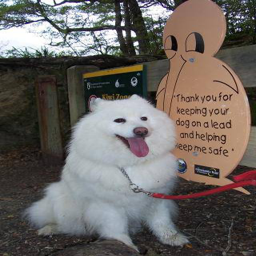

In [5]:
import torchvision
from torchvision import datasets, models, transforms


class DFImageDataset(torch.utils.data.Dataset):
    """DataFrame Image dataset.

    Reference:
        https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class
    """

    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df.copy()
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = sorted(dev_data.label.unique())
        self.df.label = self.df.label.map(self.classes.index)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file, label = self.df[['file', 'label']].iloc[idx].values
        img_path = self.root_dir/file
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


trn_ds = DFImageDataset(data['train'], '.')
trn_ds[0][0]

In [6]:
cfg = EasyDict()
cfg.crop_size = 224
cfg.load_size = 256

transforms.RandomResizedCrop
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(cfg.load_size),
        transforms.RandomResizedCrop(cfg.crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(cfg.load_size),
        transforms.CenterCrop(cfg.crop_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

datasets = {x: DFImageDataset(data[x], '.', data_transforms[x])
            for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=16,
                                              shuffle=True if x == 'train' else False,
                                              num_workers=12)
              for x in ['train', 'val']}
classes = datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

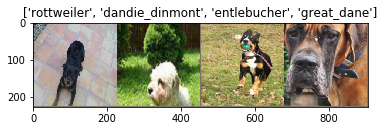

In [8]:
deterministic_everything()

# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))

# Restrict number of items to show ... 4?
inputs, labels = inputs[:4], labels[:4]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes[label] for label in labels])

In [9]:
import copy
import time


def train_model(model, criterion, optimizer, scheduler, num_epochs=25,
                seed=42, batch_tfm=None):
    
    deterministic_everything(seed)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                if batch_tfm:
                    inputs, labels = batch_tfm.transform(inputs, labels, phase=='train')

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                if isinstance(labels, list):
                    labels = labels[0]
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            opt_prms = optimizer.param_groups[0]
            print('Epoch {}/{} lr: {:.7f}'.format(epoch + 1, num_epochs, opt_prms['lr']), end='')

            print('  {} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def build_resnet(model_fn, set_trainable_fc_only=True):
    model = model_fn(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(classes))

    if set_trainable_fc_only:
        torch_set_trainable(model, False)
        torch_set_trainable(model, True, pattern='fc.+')

    model = model.to(device)

    torch_show_model(model, only_trainable=True)
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'gt: {classes[labels[j]]}, predicted: {classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
def torch_show_model(model, only_trainable=False):
    skip_count = 0
    if only_trainable:
        print('Trainable parameters:')
    for name, param in model.named_parameters():
        if only_trainable and (not param.requires_grad):
            skip_count += 1; continue
        print(name, list(param.shape), '' if param.requires_grad else '*frosen')
    if skip_count > 0:
        print(f'(and more {skip_count} frozen paramters)')

def torch_set_trainable(model, trainable, pattern='.+'):
    for name, param in model.named_parameters():
        if re.search(pattern, name):
            param.requires_grad = trainable

## resnet18

In [11]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(classes))

torch_set_trainable(model, False)
torch_set_trainable(model, True, pattern='fc.+')

torch_show_model(model, only_trainable=True)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=5)

Trainable parameters:
fc.weight [120, 512] 
fc.bias [120] 
(and more 60 frozen paramters)
Epoch 1/5 lr: 0.0010000  train Loss: 3.0695 Acc: 0.3102
Epoch 1/5 lr: 0.0010000  val Loss: 1.4721 Acc: 0.6064
Epoch 2/5 lr: 0.0010000  train Loss: 1.8349 Acc: 0.5320
Epoch 2/5 lr: 0.0010000  val Loss: 1.1217 Acc: 0.6647
Epoch 3/5 lr: 0.0010000  train Loss: 1.5464 Acc: 0.5961
Epoch 3/5 lr: 0.0010000  val Loss: 1.0316 Acc: 0.6870
Epoch 4/5 lr: 0.0010000  train Loss: 1.4316 Acc: 0.6141
Epoch 4/5 lr: 0.0010000  val Loss: 1.0418 Acc: 0.6811
Epoch 5/5 lr: 0.0010000  train Loss: 1.3797 Acc: 0.6225
Epoch 5/5 lr: 0.0010000  val Loss: 0.9849 Acc: 0.7070
Training complete in 0m 44s
Best val Acc: 0.706964


Epoch 1/10 lr: 0.0000100  train Loss: 1.0888 Acc: 0.7098
Epoch 1/10 lr: 0.0000100  val Loss: 0.8330 Acc: 0.7520
Epoch 2/10 lr: 0.0000100  train Loss: 1.0037 Acc: 0.7382
Epoch 2/10 lr: 0.0000100  val Loss: 0.7992 Acc: 0.7602
Epoch 3/10 lr: 0.0000100  train Loss: 0.9237 Acc: 0.7580
Epoch 3/10 lr: 0.0000100  val Loss: 0.7933 Acc: 0.7594
Epoch 4/10 lr: 0.0000100  train Loss: 0.8771 Acc: 0.7768
Epoch 4/10 lr: 0.0000100  val Loss: 0.8064 Acc: 0.7570
Epoch 5/10 lr: 0.0000100  train Loss: 0.8509 Acc: 0.7870
Epoch 5/10 lr: 0.0000100  val Loss: 0.7903 Acc: 0.7590
Epoch 6/10 lr: 0.0000100  train Loss: 0.9327 Acc: 0.7568
Epoch 6/10 lr: 0.0000100  val Loss: 0.7796 Acc: 0.7692
Epoch 7/10 lr: 0.0000010  train Loss: 0.8904 Acc: 0.7636
Epoch 7/10 lr: 0.0000010  val Loss: 0.7729 Acc: 0.7676
Epoch 8/10 lr: 0.0000010  train Loss: 0.8699 Acc: 0.7707
Epoch 8/10 lr: 0.0000010  val Loss: 0.7719 Acc: 0.7680
Epoch 9/10 lr: 0.0000010  train Loss: 0.8423 Acc: 0.7805
Epoch 9/10 lr: 0.0000010  val Loss: 0.7516 Acc:

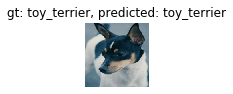

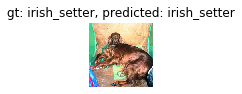

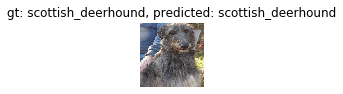

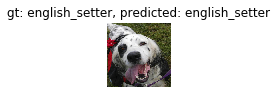

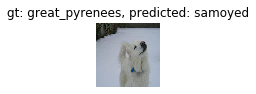

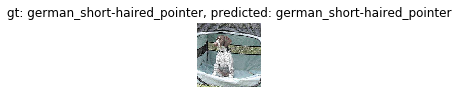

In [12]:
torch_set_trainable(model, True)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

visualize_model(model)

## resnet18 with mixup

In [14]:
model = build_resnet(models.resnet18)

criterion = nn.CrossEntropyLoss()
batch_tfm = IntraBatchMixup(criterion)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model = train_model(model, batch_tfm.criterion, optimizer, scheduler,
                       num_epochs=20, batch_tfm=batch_tfm)

Trainable parameters:
fc.weight [120, 512] 
fc.bias [120] 
(and more 60 frozen paramters)
Epoch 1/20 lr: 0.0010000  train Loss: 3.8938 Acc: 0.2176
Epoch 1/20 lr: 0.0010000  val Loss: 1.8355 Acc: 0.5587
Epoch 2/20 lr: 0.0010000  train Loss: 3.0575 Acc: 0.4191
Epoch 2/20 lr: 0.0010000  val Loss: 1.3853 Acc: 0.6326
Epoch 3/20 lr: 0.0010000  train Loss: 2.9132 Acc: 0.4684
Epoch 3/20 lr: 0.0010000  val Loss: 1.2635 Acc: 0.6444
Epoch 4/20 lr: 0.0010000  train Loss: 2.8564 Acc: 0.4919
Epoch 4/20 lr: 0.0010000  val Loss: 1.2256 Acc: 0.6565
Epoch 5/20 lr: 0.0010000  train Loss: 2.8134 Acc: 0.5063
Epoch 5/20 lr: 0.0010000  val Loss: 1.1091 Acc: 0.6890
Epoch 6/20 lr: 0.0010000  train Loss: 2.7720 Acc: 0.5141
Epoch 6/20 lr: 0.0010000  val Loss: 1.1233 Acc: 0.6862
Epoch 7/20 lr: 0.0010000  train Loss: 2.7720 Acc: 0.5205
Epoch 7/20 lr: 0.0010000  val Loss: 1.1621 Acc: 0.6741
Epoch 8/20 lr: 0.0010000  train Loss: 2.7821 Acc: 0.5226
Epoch 8/20 lr: 0.0010000  val Loss: 1.1411 Acc: 0.6808
Epoch 9/20 lr:

In [15]:
torch_set_trainable(model, True)

criterion = nn.CrossEntropyLoss()
batch_tfm = IntraBatchMixup(criterion)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

model = train_model(model, batch_tfm.criterion, optimizer, scheduler,
                       num_epochs=40, batch_tfm=batch_tfm)

Epoch 1/40 lr: 0.0000100  train Loss: 2.3975 Acc: 0.6479
Epoch 1/40 lr: 0.0000100  val Loss: 0.9695 Acc: 0.7359
Epoch 2/40 lr: 0.0000100  train Loss: 2.3663 Acc: 0.6649
Epoch 2/40 lr: 0.0000100  val Loss: 0.9712 Acc: 0.7394
Epoch 3/40 lr: 0.0000100  train Loss: 2.3438 Acc: 0.6671
Epoch 3/40 lr: 0.0000100  val Loss: 0.9572 Acc: 0.7426
Epoch 4/40 lr: 0.0000100  train Loss: 2.3267 Acc: 0.6709
Epoch 4/40 lr: 0.0000100  val Loss: 0.9925 Acc: 0.7379
Epoch 5/40 lr: 0.0000100  train Loss: 2.2959 Acc: 0.6807
Epoch 5/40 lr: 0.0000100  val Loss: 0.9815 Acc: 0.7418
Epoch 6/40 lr: 0.0000100  train Loss: 2.2548 Acc: 0.6959
Epoch 6/40 lr: 0.0000100  val Loss: 0.9908 Acc: 0.7402
Epoch 7/40 lr: 0.0000100  train Loss: 2.2389 Acc: 0.7014
Epoch 7/40 lr: 0.0000100  val Loss: 0.9815 Acc: 0.7414
Epoch 8/40 lr: 0.0000100  train Loss: 2.2416 Acc: 0.7068
Epoch 8/40 lr: 0.0000100  val Loss: 0.9871 Acc: 0.7379
Epoch 9/40 lr: 0.0000100  train Loss: 2.1888 Acc: 0.7198
Epoch 9/40 lr: 0.0000100  val Loss: 0.9862 Acc:

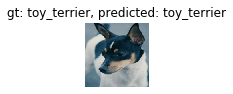

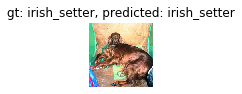

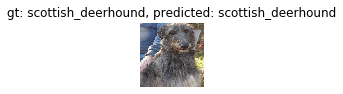

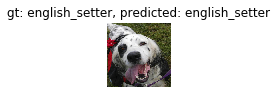

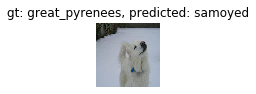

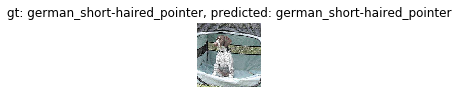

In [16]:
visualize_model(model)

## densenet121

In [27]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, len(classes))

torch_set_trainable(model, False)
torch_set_trainable(model, True, pattern='classifier.+')

torch_show_model(model, only_trainable=True)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Trainable parameters:
classifier.weight [120, 1024] 
classifier.bias [120] 
(and more 362 frozen paramters)
Epoch 1/5 lr: 0.0010000  train Loss: 2.9070 Acc: 0.3628
Epoch 1/5 lr: 0.0010000  val Loss: 1.2944 Acc: 0.6796
Epoch 2/5 lr: 0.0010000  train Loss: 1.6174 Acc: 0.5957
Epoch 2/5 lr: 0.0010000  val Loss: 0.8960 Acc: 0.7437
Epoch 3/5 lr: 0.0010000  train Loss: 1.3418 Acc: 0.6478
Epoch 3/5 lr: 0.0010000  val Loss: 0.7896 Acc: 0.7696
Epoch 4/5 lr: 0.0010000  train Loss: 1.2244 Acc: 0.6675
Epoch 4/5 lr: 0.0010000  val Loss: 0.8322 Acc: 0.7457
Epoch 5/5 lr: 0.0010000  train Loss: 1.1562 Acc: 0.6858
Epoch 5/5 lr: 0.0010000  val Loss: 0.7455 Acc: 0.7782
Training complete in 2m 7s
Best val Acc: 0.778169


Epoch 1/10 lr: 0.0000100  train Loss: 2.5339 Acc: 0.6558
Epoch 1/10 lr: 0.0000100  val Loss: 0.8841 Acc: 0.7625
Epoch 2/10 lr: 0.0000100  train Loss: 2.4379 Acc: 0.6687
Epoch 2/10 lr: 0.0000100  val Loss: 0.8449 Acc: 0.7731
Epoch 3/10 lr: 0.0000100  train Loss: 2.3849 Acc: 0.6787
Epoch 3/10 lr: 0.0000100  val Loss: 0.8189 Acc: 0.7833
Epoch 4/10 lr: 0.0000100  train Loss: 2.3537 Acc: 0.6795
Epoch 4/10 lr: 0.0000100  val Loss: 0.8803 Acc: 0.7762
Epoch 5/10 lr: 0.0000010  train Loss: 2.3060 Acc: 0.6936
Epoch 5/10 lr: 0.0000010  val Loss: 0.8476 Acc: 0.7883
Epoch 6/10 lr: 0.0000010  train Loss: 2.2737 Acc: 0.7095
Epoch 6/10 lr: 0.0000010  val Loss: 0.8589 Acc: 0.7813
Epoch 7/10 lr: 0.0000010  train Loss: 2.2667 Acc: 0.7145
Epoch 7/10 lr: 0.0000010  val Loss: 0.8794 Acc: 0.7825
Epoch 8/10 lr: 0.0000010  train Loss: 2.2899 Acc: 0.7052
Epoch 8/10 lr: 0.0000010  val Loss: 0.8811 Acc: 0.7715
Epoch 9/10 lr: 0.0000010  train Loss: 2.2500 Acc: 0.7135
Epoch 9/10 lr: 0.0000010  val Loss: 0.8658 Acc:

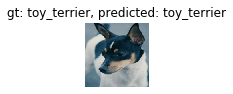

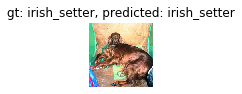

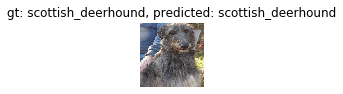

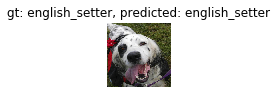

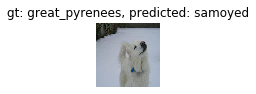

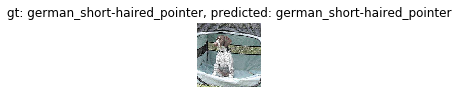

In [28]:
torch_set_trainable(model, True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

visualize_model(model)

## efficientnet_b2, 3a

Couldn't make these models works better.

In [51]:
import timm

model = timm.create_model('efficientnet_b3a', num_classes=len(classes), pretrained=True)

torch_set_trainable(model, False)
torch_set_trainable(model, True, pattern='conv_head.+')
torch_set_trainable(model, True, pattern='^bn2.+')
torch_set_trainable(model, True, pattern='classifier.+')

torch_show_model(model, only_trainable=True)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Trainable parameters:
conv_head.weight [1536, 384, 1, 1] 
bn2.weight [1536] 
bn2.bias [1536] 
classifier.weight [120, 1536] 
classifier.bias [120] 
(and more 335 frozen paramters)
Epoch 1/5 lr: 0.0010000  train Loss: 2.2532 Acc: 0.4615
Epoch 1/5 lr: 0.0010000  val Loss: 1.7056 Acc: 0.5610
Epoch 2/5 lr: 0.0010000  train Loss: 1.3925 Acc: 0.6308
Epoch 2/5 lr: 0.0010000  val Loss: 1.4856 Acc: 0.6166
Epoch 3/5 lr: 0.0010000  train Loss: 1.1949 Acc: 0.6786
Epoch 3/5 lr: 0.0010000  val Loss: 1.4821 Acc: 0.6123
Epoch 4/5 lr: 0.0010000  train Loss: 1.0895 Acc: 0.7019
Epoch 4/5 lr: 0.0010000  val Loss: 1.7197 Acc: 0.5716
Epoch 5/5 lr: 0.0001000  train Loss: 1.0348 Acc: 0.7125


KeyboardInterrupt: 

In [ ]:
torch_set_trainable(model, True)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

## resnext50_32x4d

In [30]:
model = build_resnet(models.resnext50_32x4d)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Trainable parameters:
fc.weight [120, 2048] 
fc.bias [120] 
(and more 159 frozen paramters)
Epoch 1/5 lr: 0.0010000  train Loss: 2.2203 Acc: 0.5009
Epoch 1/5 lr: 0.0010000  val Loss: 0.7609 Acc: 0.7915
Epoch 2/5 lr: 0.0010000  train Loss: 1.1674 Acc: 0.6843
Epoch 2/5 lr: 0.0010000  val Loss: 0.5668 Acc: 0.8298
Epoch 3/5 lr: 0.0010000  train Loss: 1.0420 Acc: 0.7181
Epoch 3/5 lr: 0.0010000  val Loss: 0.5613 Acc: 0.8353
Epoch 4/5 lr: 0.0010000  train Loss: 0.9946 Acc: 0.7233
Epoch 4/5 lr: 0.0010000  val Loss: 0.6440 Acc: 0.8114
Epoch 5/5 lr: 0.0010000  train Loss: 0.9943 Acc: 0.7266
Epoch 5/5 lr: 0.0010000  val Loss: 0.6657 Acc: 0.8138
Training complete in 2m 7s
Best val Acc: 0.835290


Epoch 1/10 lr: 0.0000100  train Loss: 0.6463 Acc: 0.8213
Epoch 1/10 lr: 0.0000100  val Loss: 0.4126 Acc: 0.8701
Epoch 2/10 lr: 0.0000100  train Loss: 0.5143 Acc: 0.8638
Epoch 2/10 lr: 0.0000100  val Loss: 0.3941 Acc: 0.8740
Epoch 3/10 lr: 0.0000100  train Loss: 0.4338 Acc: 0.8891
Epoch 3/10 lr: 0.0000100  val Loss: 0.3991 Acc: 0.8736
Epoch 4/10 lr: 0.0000100  train Loss: 0.5630 Acc: 0.8471
Epoch 4/10 lr: 0.0000100  val Loss: 0.4331 Acc: 0.8638
Epoch 5/10 lr: 0.0000010  train Loss: 0.5431 Acc: 0.8544
Epoch 5/10 lr: 0.0000010  val Loss: 0.4108 Acc: 0.8705
Epoch 6/10 lr: 0.0000010  train Loss: 0.5138 Acc: 0.8677
Epoch 6/10 lr: 0.0000010  val Loss: 0.4035 Acc: 0.8728
Epoch 7/10 lr: 0.0000010  train Loss: 0.4751 Acc: 0.8740
Epoch 7/10 lr: 0.0000010  val Loss: 0.4026 Acc: 0.8721
Epoch 8/10 lr: 0.0000010  train Loss: 0.4728 Acc: 0.8774
Epoch 8/10 lr: 0.0000010  val Loss: 0.3878 Acc: 0.8795
Epoch 9/10 lr: 0.0000010  train Loss: 0.4611 Acc: 0.8796
Epoch 9/10 lr: 0.0000010  val Loss: 0.3818 Acc:

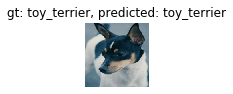

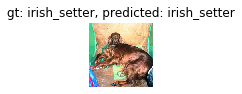

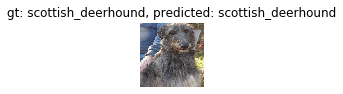

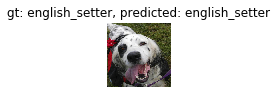

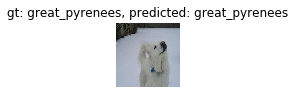

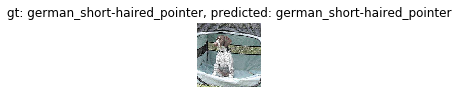

In [31]:
torch_set_trainable(model, True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

visualize_model(model)

## swsl_resnext50_32x4d

In [57]:
model = timm.create_model('swsl_resnext50_32x4d', num_classes=len(classes), pretrained=True)
torch_set_trainable(model, False)
torch_set_trainable(model, True, pattern='fc.+')
model = model.to(device)
torch_show_model(model, only_trainable=True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Trainable parameters:
fc.weight [120, 2048] 
fc.bias [120] 
(and more 159 frozen paramters)
Epoch 1/5 lr: 0.0010000  train Loss: 1.7908 Acc: 0.5905
Epoch 1/5 lr: 0.0010000  val Loss: 0.5510 Acc: 0.8396
Epoch 2/5 lr: 0.0010000  train Loss: 1.0807 Acc: 0.7104
Epoch 2/5 lr: 0.0010000  val Loss: 0.4454 Acc: 0.8631
Epoch 3/5 lr: 0.0010000  train Loss: 1.0069 Acc: 0.7301
Epoch 3/5 lr: 0.0010000  val Loss: 0.4476 Acc: 0.8748
Epoch 4/5 lr: 0.0010000  train Loss: 0.9989 Acc: 0.7422
Epoch 4/5 lr: 0.0010000  val Loss: 0.4987 Acc: 0.8592
Epoch 5/5 lr: 0.0001000  train Loss: 1.0026 Acc: 0.7494
Epoch 5/5 lr: 0.0001000  val Loss: 0.5127 Acc: 0.8744
Training complete in 2m 7s
Best val Acc: 0.874804


In [58]:
torch_set_trainable(model, True)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Epoch 1/5 lr: 0.0000100  train Loss: 0.6545 Acc: 0.8149
Epoch 1/5 lr: 0.0000100  val Loss: 0.4126 Acc: 0.8807
Epoch 2/5 lr: 0.0000100  train Loss: 0.5489 Acc: 0.8431
Epoch 2/5 lr: 0.0000100  val Loss: 0.3813 Acc: 0.8858
Epoch 3/5 lr: 0.0000100  train Loss: 0.4422 Acc: 0.8737
Epoch 3/5 lr: 0.0000100  val Loss: 0.4052 Acc: 0.8807
Epoch 4/5 lr: 0.0000100  train Loss: 0.5367 Acc: 0.8486
Epoch 4/5 lr: 0.0000100  val Loss: 0.4575 Acc: 0.8764
Epoch 5/5 lr: 0.0000010  train Loss: 0.5002 Acc: 0.8628
Epoch 5/5 lr: 0.0000010  val Loss: 0.4565 Acc: 0.8685
Training complete in 6m 14s
Best val Acc: 0.885759


## resnet50

In [42]:
model = timm.create_model('resnet50', num_classes=len(classes), pretrained=True)
torch_set_trainable(model, False)
torch_set_trainable(model, True, pattern='fc.+')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Epoch 1/5 lr: 0.0010000  train Loss: 2.1006 Acc: 0.5526
Epoch 1/5 lr: 0.0010000  val Loss: 0.6500 Acc: 0.8165
Epoch 2/5 lr: 0.0010000  train Loss: 1.2088 Acc: 0.6891
Epoch 2/5 lr: 0.0010000  val Loss: 0.5072 Acc: 0.8513
Epoch 3/5 lr: 0.0010000  train Loss: 1.0645 Acc: 0.7210
Epoch 3/5 lr: 0.0010000  val Loss: 0.5134 Acc: 0.8439
Epoch 4/5 lr: 0.0010000  train Loss: 1.0052 Acc: 0.7253
Epoch 4/5 lr: 0.0010000  val Loss: 0.5311 Acc: 0.8392
Epoch 5/5 lr: 0.0001000  train Loss: 0.9642 Acc: 0.7357
Epoch 5/5 lr: 0.0001000  val Loss: 0.5244 Acc: 0.8415
Training complete in 1m 41s
Best val Acc: 0.851330


In [44]:
torch_set_trainable(model, True)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Epoch 1/5 lr: 0.0000100  train Loss: 0.6647 Acc: 0.8187
Epoch 1/5 lr: 0.0000100  val Loss: 0.4476 Acc: 0.8603
Epoch 2/5 lr: 0.0000100  train Loss: 0.6017 Acc: 0.8397
Epoch 2/5 lr: 0.0000100  val Loss: 0.4266 Acc: 0.8697
Epoch 3/5 lr: 0.0000100  train Loss: 0.7188 Acc: 0.7999
Epoch 3/5 lr: 0.0000100  val Loss: 0.4538 Acc: 0.8627
Epoch 4/5 lr: 0.0000100  train Loss: 0.6795 Acc: 0.8093
Epoch 4/5 lr: 0.0000100  val Loss: 0.4612 Acc: 0.8572
Epoch 5/5 lr: 0.0000100  train Loss: 0.6569 Acc: 0.8212
Epoch 5/5 lr: 0.0000100  val Loss: 0.4753 Acc: 0.8580
Training complete in 4m 44s
Best val Acc: 0.869718


## resnext101_32x8d

In [45]:
model = build_resnet(models.resnext101_32x8d)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Trainable parameters:
fc.weight [120, 2048] 
fc.bias [120] 
(and more 312 frozen paramters)
Epoch 1/5 lr: 0.0010000  train Loss: 1.6993 Acc: 0.6222
Epoch 1/5 lr: 0.0010000  val Loss: 0.4670 Acc: 0.8568
Epoch 2/5 lr: 0.0010000  train Loss: 0.8291 Acc: 0.7702
Epoch 2/5 lr: 0.0010000  val Loss: 0.3624 Acc: 0.8834
Epoch 3/5 lr: 0.0010000  train Loss: 0.7461 Acc: 0.7909
Epoch 3/5 lr: 0.0010000  val Loss: 0.3538 Acc: 0.8854
Epoch 4/5 lr: 0.0010000  train Loss: 0.7205 Acc: 0.8015
Epoch 4/5 lr: 0.0010000  val Loss: 0.3933 Acc: 0.8822
Epoch 5/5 lr: 0.0010000  train Loss: 0.6998 Acc: 0.8115
Epoch 5/5 lr: 0.0010000  val Loss: 0.4088 Acc: 0.8791
Training complete in 5m 29s
Best val Acc: 0.885368


Epoch 1/5 lr: 0.0000100  train Loss: 0.4692 Acc: 0.8612
Epoch 1/5 lr: 0.0000100  val Loss: 0.2972 Acc: 0.9034
Epoch 2/5 lr: 0.0000100  train Loss: 0.3751 Acc: 0.8985
Epoch 2/5 lr: 0.0000100  val Loss: 0.3005 Acc: 0.9065
Epoch 3/5 lr: 0.0000100  train Loss: 0.2948 Acc: 0.9264
Epoch 3/5 lr: 0.0000100  val Loss: 0.3076 Acc: 0.9026
Epoch 4/5 lr: 0.0000100  train Loss: 0.4017 Acc: 0.8938
Epoch 4/5 lr: 0.0000100  val Loss: 0.3501 Acc: 0.8905
Epoch 5/5 lr: 0.0000100  train Loss: 0.3778 Acc: 0.9001
Epoch 5/5 lr: 0.0000100  val Loss: 0.3411 Acc: 0.8924
Training complete in 16m 14s
Best val Acc: 0.906495


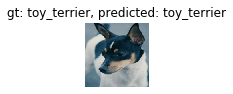

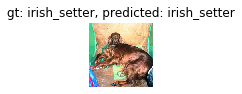

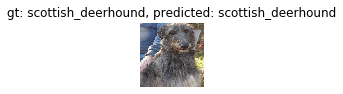

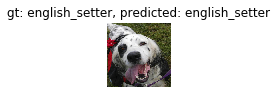

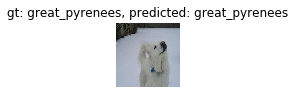

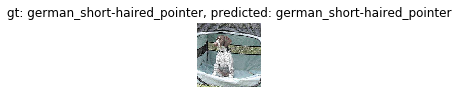

In [46]:
torch_set_trainable(model, True)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

visualize_model(model)

## resnext101_32x8d with weak augmentations

RandomResizedCrop -> RandomCrop.

Weak data augmentation raises val acc much better, but with severe overfitting.
I'm too nervous to use this, very anxious about performance with unseen samples.

In [14]:
model = build_resnet(models.resnext101_32x8d)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

Trainable parameters:
fc.weight [120, 2048] 
fc.bias [120] 
(and more 312 frozen paramters)
Epoch 1/5 lr: 0.0010000  train Loss: 1.2005 Acc: 0.7374
Epoch 1/5 lr: 0.0010000  val Loss: 0.4347 Acc: 0.8670
Epoch 2/5 lr: 0.0010000  train Loss: 0.3796 Acc: 0.8822
Epoch 2/5 lr: 0.0010000  val Loss: 0.3410 Acc: 0.8908
Epoch 3/5 lr: 0.0010000  train Loss: 0.3000 Acc: 0.9097
Epoch 3/5 lr: 0.0010000  val Loss: 0.3289 Acc: 0.8995
Epoch 4/5 lr: 0.0010000  train Loss: 0.2651 Acc: 0.9110
Epoch 4/5 lr: 0.0010000  val Loss: 0.3340 Acc: 0.9022
Epoch 5/5 lr: 0.0010000  train Loss: 0.2165 Acc: 0.9281
Epoch 5/5 lr: 0.0010000  val Loss: 0.3917 Acc: 0.8850
Training complete in 5m 30s
Best val Acc: 0.902191


Epoch 1/5 lr: 0.0000100  train Loss: 0.1405 Acc: 0.9571
Epoch 1/5 lr: 0.0000100  val Loss: 0.2941 Acc: 0.9073
Epoch 2/5 lr: 0.0000100  train Loss: 0.0688 Acc: 0.9836
Epoch 2/5 lr: 0.0000100  val Loss: 0.3037 Acc: 0.9077
Epoch 3/5 lr: 0.0000100  train Loss: 0.0421 Acc: 0.9911
Epoch 3/5 lr: 0.0000100  val Loss: 0.2875 Acc: 0.9159
Epoch 4/5 lr: 0.0000100  train Loss: 0.0307 Acc: 0.9953
Epoch 4/5 lr: 0.0000100  val Loss: 0.3059 Acc: 0.9112
Epoch 5/5 lr: 0.0000100  train Loss: 0.0386 Acc: 0.9915
Epoch 5/5 lr: 0.0000100  val Loss: 0.3280 Acc: 0.9022
Training complete in 16m 14s
Best val Acc: 0.915884


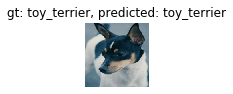

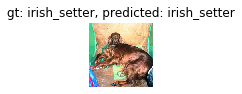

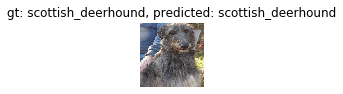

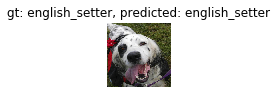

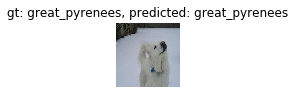

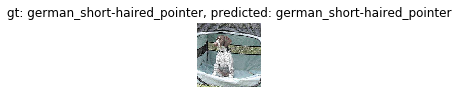

In [15]:
torch_set_trainable(model, True)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

visualize_model(model)